In [ ]:
! pip install arch

In [ ]:
! pip install numpy 

In [ ]:
! pip install matplotlib

In [ ]:
! pip install scikit-learn

## Importation des librairies

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

## Echantillonnage des données simulées selon un modèle GARCH(1,1)  

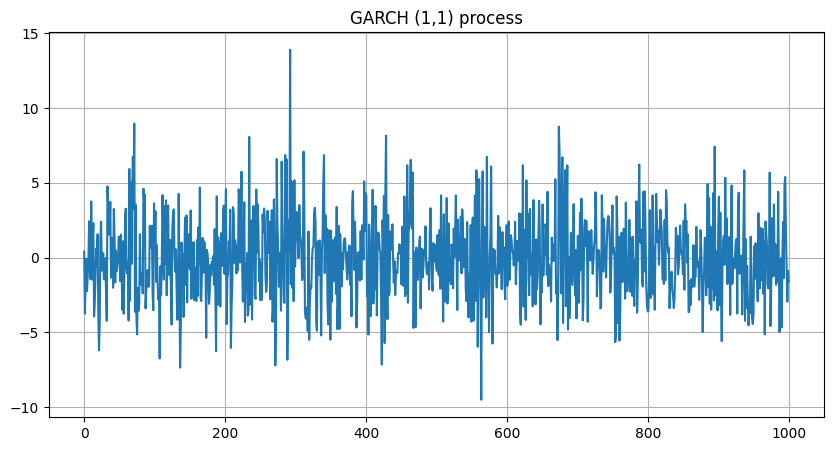

In [7]:

np.random.seed(12345)

n = 1000        # n le nombre d'observations à générer
n1 = 100        # n1 est le nombre des observations premières qu'on supprime de l'échantillon 
n2 = n + n1     # n2 est le nombre de simulations total

# Les paramètres de GARCH(1,1)
omega = 1
alpha = 0.2   
beta = 0.7

errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega

for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]

h = h2[n1-1:-1]
y = r[n1-1:-1]    # On élimine les premières observations

plt.figure(figsize=(10, 5))
plt.title('GARCH (1,1) process')
x = range(n) 
plt.plot(x,y)
plt.grid(True)
plt.show()

## Récupération des données réelles 

On calcule la transformation logarithmique du taux de change Euro/US Dollar journalier sur la période entre 24/04/2021 et 24/04/2024.

Source : https://www.investing.com/currencies/eur-usd-historical-data

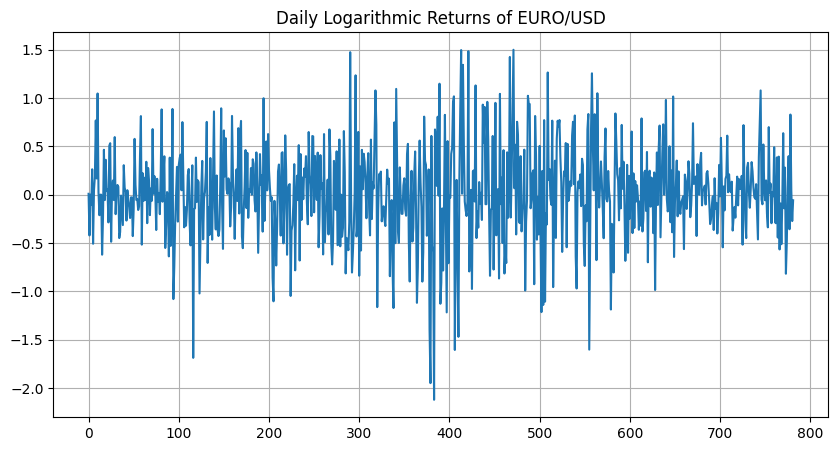

In [138]:
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)

plt.figure(figsize=(10, 5))
plt.title('Daily Logarithmic Returns of EURO/USD')
x = range(len(r)) 
plt.plot(x,r)
plt.grid(True)
plt.show()


## Metropolis sampler

Pour répondre à la question, nous implémentons un random walk Metropolis sampler qui cible la distribution à posteriori des paramètres d'un GARCH(1,1). Pour ce faire, nous suivrons les étapes suivantes : 

1. Implémentation de la distribution à priori (priors) : nous avons choisi une loi normale tronquée pour chaque paramètre wi comme dans l'article. En effet, les para
   Nous avons fait le choix de prendre de grandes variances pour que la distribution à posteriori reflète essentiellement les données et non pas nos propres croyances. De plus, w1, w2 et w3 sont supposées indépendants.

2. Implémentation de la vraisemblance 
3. Déduction de la distribution à posteriori

In [143]:
# 1. Distribution a priori de (w1, w2, w3)

def prior(omega, var):
    """
        omega (list): le vecteur des paramètres [w1,w2,w3]
        var (list): le vecteur des variances des lois normales
    """
    P = 1
    for i in range (len(omega)):
        if omega[i] > 0 :
            P = P* np.exp(-0.5 * (omega[i]**2/var[i]))
        else : 
            return 0
    return P


# 2. Fonction de log-vraisemblance conditionnelle du modèle GARCH log(L(r/w))

def likelihood(returns, omega):
    T = 100
    h = np.zeros(T)
    h[0] = np.var(returns) # à la première valeur de h on associe la variance des taux d'intérêt.
    
    for t in range(1, T):
        h[t] = omega[0] + omega[2] * h[t-1] + omega[1] * (returns[t-1] ** 2)
    L = np.prod((10/np.sqrt(h)) * np.exp(-0.5*(np.array(returns[:100])**2)/h))
    return L




# 3. Distribution à posteriori

def posterior (returns, omega, var) :
    return prior (omega,var) * likelihood(returns,omega)

4. Echantionnage avec l'algorithme Metropolis-Hasting  


In [181]:

# Probabilité de transition de x vers y et de y vers x 

def q(x, y, sigma):
    if np.linalg.det(sigma) == 0 :
        return 1
    else :
        sigma_inv = np.linalg.inv(sigma)
        q = (1 / (np.sqrt((2 * np.pi)**3 * np.linalg.det(sigma)))) * np.exp(-0.5 * np.dot(np.dot((y - x).T, sigma_inv), (y - x)))
        return q

def metropolis (returns, omega_current, n_iter, var, c):
    
    # On initialise le nombre d'omegas acceptés dans l'algorithme
    j = 0 

    # omega_matrix est la matrice de notre échantillon, on stocke la valeur initiale du vecteur omega
    omega_matrix = omega_current 

    # c*sigma est un estimateur de la matrice de variance-covariance de la distribution à posteriori
    # On initialise sigma par la matrice identité, elle sera actualisé par la méthode 'adaptive MCMC'
    sigma = np.eye(3) 
    np.random.seed(12)
    for i in range (0,n_iter):

        # Proposer un nouveau jeu de paramètres omega_n qui correspond à Y et omega_current c'est Xn-1.
        omega_n = omega_current + abs(np.random.multivariate_normal(np.array([0,0,0]), sigma*c))

        # Calcul de r(x, y) ; Dans notre cas, q_ratio = 1
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)

        # Affectation de la valeur de Xn : Xn = Y avec une proba = min (1,r)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1

        # Ajout du nouveau vecteur des omégas à notre matrice 
        omega_matrix = np.vstack((omega_matrix, omega_current)) 

        # On centre notre échantillon
        mean_X = np.mean(omega_matrix, axis=0)
        centered_omega = omega_matrix - mean_X

        # Actualisation de la matrice de variance-covariance empirique sigma avec 'adaptive MCMC'
        sigma = np.cov(centered_omega, rowvar=False)
    
    # j/n_iter est le taux d'acceptation et omega_matrix est notre échantillon pour une valeur donnée de c
    return j/n_iter, centered_omega, np.mean(centered_omega, axis=0)


def c_optimal (returns, omega_current, n_iter,var, a, b):

    # T est une liste qui stocke les taux d'acceptation pour plusieurs valeurs de c
    T=[] 

    # on se donne un certain nombre de valeurs de c dans un intervalle [a,b]
    C = np.linspace(a,b,1000) 
    
    for c in C :
        taux = metropolis (returns, omega_current, n_iter, var, c)[0]
        T.append (taux)

    plt.plot(C,T)
    plt.show()
    return T


In [ ]:
## Pour les données simulées y
J1 = c_optimal (y, np.array([1,1,1]), 100000,[1,1,1], 0.001, 1)
# En regardant le taux d'acceptance pour différentes valeurs de c, la valeur de c qui donne un taux d'acceptance de l'ordre de 0.25 est 
# c* = 0.0005

## Pour les données réelles r
J2 = c_optimal (r, np.array([1,1,1]), 100000,[1,1,1], 0.001, 1)
# La valeur optimale de c est c* = 0.0005

## Ordinary MCMC

In [182]:
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
n_iter = 10000

c_opt_sim = 1/5000
echant_sim = metropolis (y, omega_current, n_iter, var, c_opt_sim)[1]
accep_rate_sim = metropolis (y, omega_current, n_iter, var, c_opt_sim)[0]

c_opt_reel = 1/5000
echant_reel = metropolis (r, omega_current, n_iter, var, c_opt_reel)[1]
accep_rate_reel = metropolis (r, omega_current, n_iter, var, c_opt_reel)[0]


In [186]:
m1 = metropolis (r, omega_current, n_iter, var, c_opt_reel)[2]
m2 = metropolis (r, omega_current, n_iter, var, c_opt_reel)[2]
print (accep_rate_sim)
print (accep_rate_reel)
print(m1)
print(m2)
print(np.cov(echant_reel, rowvar=False))


0.2953
0.3112
[5.40022870e-14 5.77271568e-15 2.67882684e-14]
[5.40022870e-14 5.77271568e-15 2.67882684e-14]
[[0.3030412  0.43658838 0.15533057]
 [0.43658838 0.62898845 0.22378317]
 [0.15533057 0.22378317 0.07961817]]


## Visualisation de l'évolution des paramètres

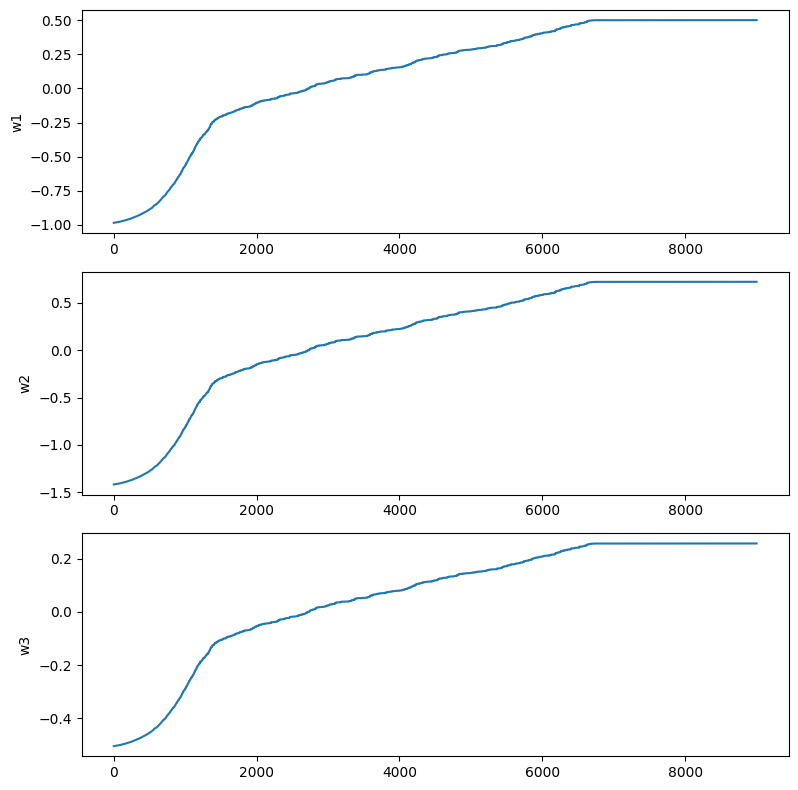

In [184]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(9001), echant_sim[1000:, 0])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), echant_sim[1000:, 1])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), echant_sim[1000:, 2])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

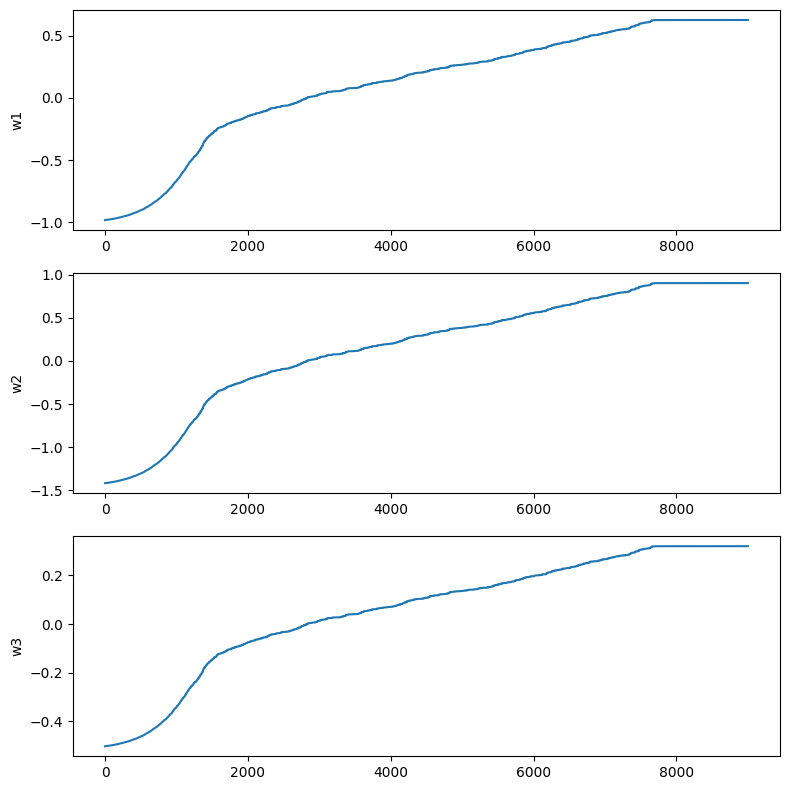

In [185]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(range(9001), echant_reel[1000:, 0])
axs[0].set_ylabel('w1')
axs[1].plot(range(9001), echant_reel[1000:, 1])
axs[1].set_ylabel('w2')
axs[2].plot(range(9001), echant_reel[1000:, 2])
axs[2].set_ylabel('w3')
plt.tight_layout()
plt.show()

## ZV-MCMC : First Order Control Variates

In [71]:
def calcul_z(omega_1, omega_2, omega_3, h, r, sigma):
    T = len(h)
    z_1 = omega_1 / (2 * sigma ** 2)
    z_2 = omega_2 / (2 * sigma ** 2)
    z_3 = omega_3 / (2 * sigma ** 2)
    
    for t in range(1,T):
        dht_domega1 = (1 - omega_3 ** (t-1)) / (1 - omega_3)
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega_2])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega_3])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    return np.column_stack([z_1, z_2, z_3])

## ZV-MCMC : Second Order Control Variates

In [72]:

def control_variates_2 (x,z):
    """
    Args:
        x (np.array): échantillon de paramètres (omega1, omega2, omega3)
        z (np.array): échantillon de variables de contrôle d'ordre 1 (z1,z2,z3)

    Returns:
        np.array: un échantillon de 9 variables de contrôle, ZV-MCMC d'ordre 2
    """
    i = np.ones(z.shape)
    u = z*x -0.5*i
    v1 = x[:,1]*z[:,0] + x[:,0]*z[:,1]
    v2 = x[:,2]*z[:,0] + x[:,0]*z[:,2]
    v3 = x[:,2]*z[:,1] + x[:,1]*z[:,2]
    v = np.column_stack((v1, v2, v3))
    vT = v.transpose()
    uT = u.transpose()
    zT = z.transpose()
    zTuTvT = np.concatenate((zT, uT, vT), axis = 0)

    # CV2 est un échantillon de même taille que x et z de 9-uplets ; Pour ZV-MCMC de degré 2 on a 9 variables de contrôles
    # Une colonne de CV2 est une variable de contôle 
    CV2 = zTuTvT.transpose()

    return CV2


First stage : Une première régression pour chaque paramètre omega_i pour déterminer les coefficients optimaux de chacune des 9 variables de contrôle.

In [76]:
def opti_coeff_CV2 (omega, CV2):
    d = dict() 
    # d est un dictionnaire qui stocke les coefficients optimaux des variables de contrôle de chacun des omega1, omega2 et omega3
    for i in [0,1,2]:
        model = LinearRegression()
        model.fit(CV2, omega[:,i])
        d['omega' + str(i+1)] = model.coef_
    return d

# Pour les données simulées
omega = metropolis (y, omega_current, n_iter, var, c_opt_sim)[1]
z = calcul_z(omega[:,0], omega[:,1], omega[:,2], h, y, var[0])
CV2_sim = control_variates_2 (omega,z)

# Pour les données réelles; COMMENT TROUVER LE H DES DONNEES REELLES !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# omega = metropolis (r, omega_current, n_iter, var, c_opt_reel)[1]
# z = calcul_z(omega[:,0], omega[:,1], omega[:,2], h, r, sigma)
# CV2_reel = control_variates_2 (omega,z)


KeyboardInterrupt: 

## Approche naïve : une seule régression

Second stage : génération des échantillons omega_tilde 

Maintenant qu'on a récupéré les coefficients optimaux des variables de contrôle avec une régression linéaire, nous générons un échantillon omega1_tilde, omega2_tilde et omega3_tilde tel que : 

    omegai_tilde = omega_i + la combinaison linéaire des variables de contrôle pondérées par les coefficients trouvés par la régression.
Cette combinaison est exactement la prédiction du modèle.

In [ ]:
def omega_tilde(omega, i, CV2, d):
    CV = CV2.copy()
    for k in range(9) :
        CV[:,k] = CV[:,k] * d['omega' + str(i)][k]
return omega[:,i] + np.sum(CV, axis = 1)

In [ ]:
d_sim = opti_coeff_CV2 (omega, CV2_sim)
omega_tilde_sim = omega_tilde(omega, 1, CV2_sim, d_sim)

## Approche LASSO : CODE NON TESTE

In [ ]:
def cross_validation(X,Y,lambda):

    k = 10  # Nombre de plis
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Effectuer la validation croisée
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lasso = Lasso(alpha=lambda)
        lasso.fit(X_train_scaled, y_train)
        predictions = lasso.predict(X_test_scaled)

        # Calculer l'erreur quadratique moyenne (MSE) des prédictions
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculer la moyenne des scores MSE sur les plis
    average_mse = np.mean(mse_scores)
    
    return average_mse

def lambda_etoile (X,Y):
    MSE = []
    LAM  = np.linspace(-100,100,1000) 
    for lambda in LAM :
        MSE.append(cross_validation(X,Y,lambda))
    i = MSE.index(MSE.min())
    return LAM[i]

def beta_LASSO (X,Y, lambda) :
    lasso = Lasso(alpha=lambda)
    lasso.fit(X, Y)
retrun lasso.coef_


def reg_penal(X,Y,beta_LASSO):
    var = []
    
    for i in len(beta_LASSO) :
        if beta_LASSO[i] != 0 :
            var.append(i)

    model = LinearRegression()
    model.fit(X[:,var], Y)

    return Y +  model.predict(X) # nos omega_tilde
